In [1]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, box

import scimap as sm

Running SCIMAP  2.1.3


In [2]:
adata = ad.read_h5ad("../data/processed/20241004_1107_991_992_knn_RCN.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value', 'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'imageid', 'phenotype', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    var: 'math', 'marker'
    uns: 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn7_probability'

In [5]:
adata.obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,imageid,phenotype,spatial_lda_knn7_kmeans_k7,spatial_lda_knn14_kmeans_k7,spatial_lda_knn21_kmeans_k7,spatial_lda_knn30_kmeans_k7,spatial_lda_knn40_kmeans_k7,spatial_lda_knn50_kmeans_k7
0,0.0,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,...,True,True,991,Cancer_cells,1,6,4,5,2,0
1,1.0,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,...,True,True,991,Cancer_cells,4,6,4,5,2,0
2,2.0,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,...,True,True,991,Cancer_cells,1,1,1,1,2,0
3,3.0,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,...,True,True,991,CD4_Tcells,3,0,6,6,1,6
4,4.0,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,...,True,True,991,Cancer_cells,1,1,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615228,1134342.0,27270.642157,37569.550980,1020.0,39.707795,32.947621,0.558132,-0.657307,121.639610,0.955951,...,True,True,992,Unknown,2,2,0,0,6,3
1615229,1134343.0,27274.343598,38996.906807,1234.0,42.622618,37.495770,0.475501,0.465532,133.781746,0.964063,...,True,True,992,Cancer_cells,1,1,0,0,6,3
1615230,1134344.0,27271.604926,37413.383251,1015.0,60.243974,22.812825,0.925530,-0.625325,144.509668,0.866041,...,True,True,992,Cancer_cells,3,2,0,0,4,3
1615231,1134345.0,27272.320411,38221.301424,1264.0,50.722945,32.740800,0.763775,-1.218716,143.681241,0.953243,...,True,True,992,Cancer_cells,4,1,1,1,4,1


In [7]:
adata.obs[['X_centroid', 'Y_centroid']].values

array([[35874.85780118, 29410.80645161],
       [36162.24313976, 29445.08040842],
       [38455.23512195, 29505.17170732],
       ...,
       [37413.38325123, 27271.60492611],
       [38221.30142405, 27272.32041139],
       [35244.59656085, 27268.72354497]])

In [13]:
imageid = 991

In [12]:
adata.obs.imageid.dtype

CategoricalDtype(categories=['991', '992'], ordered=False, categories_dtype=object)

In [17]:
assert type(imageid) == adata.obs.imageid.dtype, f"imageid dtype mismatch, {type(imageid)} =/= {adata.obs.imageid.dtype}"

SyntaxError: invalid syntax (3863254007.py, line 1)

In [18]:
str(imageid)

'991'

In [21]:
type(str(imageid))

str

In [22]:
series = adata.obs.imageid.astype(np.dtype(str))

In [23]:
series.dtype

dtype('O')

In [24]:
a = adata.copy()

In [25]:
a = a[a.obs.imageid == str(imageid)]

In [26]:
a.obs.imageid.value_counts()

imageid
991    610182
Name: count, dtype: int64

In [27]:
#step1: QC knn30 in both tissues in QuPath
importlib.reload(utils)

utils.adataobs_to_voronoi_geojson(
    df=adata.obs,
    imageid=991,
    category_1="phenotype",
    category_2="spatial_lda_knn30_kmeans_k7",
    output_path="../data/geojson_vor/"
)

2024-10-04 11:56:47.267 | DEBUG    | utils:adataobs_to_voronoi_geojson:385 -  df shape: (1615233, 28)
2024-10-04 11:56:47.394 | DEBUG    | utils:adataobs_to_voronoi_geojson:390 -  df shape after imageid subset: (610182, 28)
2024-10-04 11:56:47.395 | INFO     | utils:adataobs_to_voronoi_geojson:391 - Processing 991, loaded dataframe
2024-10-04 11:56:47.396 | INFO     | utils:adataobs_to_voronoi_geojson:407 - Running Voronoi
2024-10-04 11:56:59.888 | INFO     | utils:adataobs_to_voronoi_geojson:417 - Voronoi done
2024-10-04 11:56:59.978 | INFO     | utils:adataobs_to_voronoi_geojson:421 - Transformed to geodataframe
2024-10-04 11:56:59.981 | INFO     | utils:adataobs_to_voronoi_geojson:429 - Bounding box: x_min: 878.0318021201414, x_max: 71605.30902111324, y_min: 6.78003120124805, y_max 42764.688888888886
2024-10-04 11:57:02.785 | INFO     | utils:adataobs_to_voronoi_geojson:433 - Filtered out infinite polygons
2024-10-04 11:57:02.873 | INFO     | utils:adataobs_to_voronoi_geojson:438 - 

In [28]:
#step1: QC knn30 in both tissues in QuPath
importlib.reload(utils)

utils.adataobs_to_voronoi_geojson(
    df=adata.obs,
    imageid=992,
    category_1="phenotype",
    category_2="spatial_lda_knn30_kmeans_k7",
    output_path="../data/geojson_vor/"
)

2024-10-04 11:58:29.813 | DEBUG    | utils:adataobs_to_voronoi_geojson:385 -  df shape: (1615233, 28)
2024-10-04 11:58:29.973 | DEBUG    | utils:adataobs_to_voronoi_geojson:390 -  df shape after imageid subset: (1005051, 28)
2024-10-04 11:58:29.974 | INFO     | utils:adataobs_to_voronoi_geojson:391 - Processing 992, loaded dataframe
2024-10-04 11:58:29.974 | INFO     | utils:adataobs_to_voronoi_geojson:407 - Running Voronoi
2024-10-04 11:58:49.153 | INFO     | utils:adataobs_to_voronoi_geojson:417 - Voronoi done
2024-10-04 11:58:49.312 | INFO     | utils:adataobs_to_voronoi_geojson:421 - Transformed to geodataframe
2024-10-04 11:58:49.316 | INFO     | utils:adataobs_to_voronoi_geojson:429 - Bounding box: x_min: 2216.9608763693273, x_max: 70848.77680906713, y_min: 20.43081312410842, y_max 47084.98548812665
2024-10-04 11:58:53.969 | INFO     | utils:adataobs_to_voronoi_geojson:433 - Filtered out infinite polygons
2024-10-04 11:58:54.133 | INFO     | utils:adataobs_to_voronoi_geojson:438 

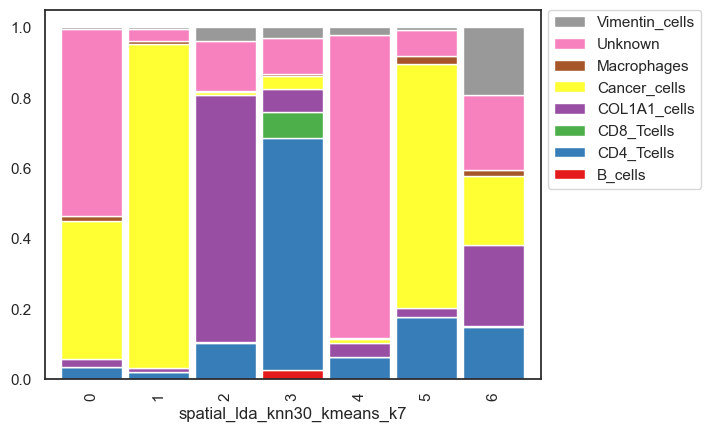

In [29]:
sm.pl.stacked_barplot (adata, x_axis='spatial_lda_knn30_kmeans_k7', y_axis='phenotype')